In [1]:
from pyrosm import OSM, get_data
import pyrosm
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Initialize the reader
osm = OSM('../data/planet_4.2624,50.357_4.5933,50.4882.osm.pbf') # downloaded from BBBike

In [2]:
source_address = "Rue Turenne 11, Charleroi"

# Create the Network

## Get all walkable roads and the nodes 

In [3]:
nodes, edges = osm.get_network(nodes=True, network_type='walking')

# Check first rows in the edge 
edges.head()

,access,bicycle,bridge,busway,cycleway,foot,footway,highway,int_ref,junction,...,width,id,timestamp,version,tags,osm_type,geometry,u,v,length
0,None,None,None,None,None,None,None,primary,None,roundabout,...,None,197574,0,0,"{""visible"":false,""maxspeed:type"":""sign""}",way,"LINESTRING (4.52797 50.45663, 4.52794 50.45655)",1547383,1103037320,8.730
1,None,None,None,None,None,None,None,primary,None,roundabout,...,None,197574,0,0,"{""visible"":false,""maxspeed:type"":""sign""}",way,"LINESTRING (4.52794 50.45655, 4.52794 50.45648)",1103037320,38464169,8.488
2,None,None,None,None,None,None,None,trunk,None,None,...,None,4309819,0,0,"{""visible"":false,""destination"":""Gosselies"",""op...",way,"LINESTRING (4.52831 50.4568, 4.52819 50.45682)",1547382,9630157482,8.603
3,None,None,None,None,None,None,None,trunk,None,None,...,None,4309819,0,0,"{""visible"":false,""destination"":""Gosselies"",""op...",way,"LINESTRING (4.52819 50.45682, 4.52809 50.45685)",9630157482,9630157485,8.411
4,None,None,None,None,None,None,None,trunk,None,None,...,None,4309819,0,0,"{""visible"":false,""destination"":""Gosselies"",""op...",way,"LINESTRING (4.52809 50.45685, 4.52799 50.45694)",9630157485,1152757218,11.788


In [4]:
## Create a NetworkX graph

In [5]:
G = osm.to_graph(nodes, edges, graph_type="networkx")

## Check the CRS and change it to a projected CRS

In [6]:
#ox.project_graph(G, 'epsg:3812')

In [7]:
#ox.plot_graph(G)

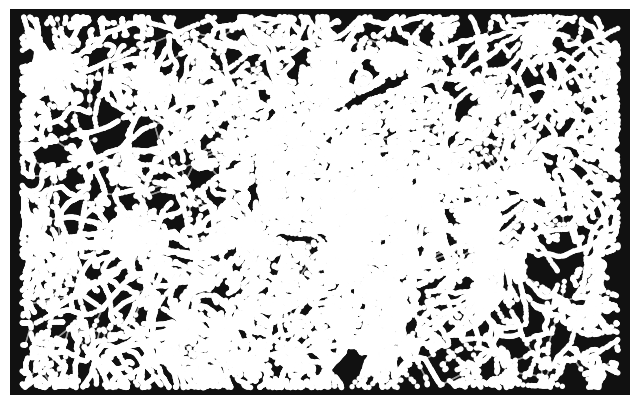

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox.plot_graph(G)

In [9]:
source = ox.geocode(source_address)

In [10]:
# Find the closest nodes from the graph
source_node = ox.nearest_nodes(G, source[1], source[0])

In [11]:
source_node

5523847758

In [12]:
trip_times = [5,10,15,20,25,30,35,40,45] # in minutes
travel_speed = 4.5 # kph
meters_per_minute = travel_speed * 1000 / 60 
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [13]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, source_node, radius=trip_time,  distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [3 if node in node_colors else 0 for node in G.nodes()]

In [14]:
for node in G.nodes():
    if node in node_colors:
        G.nodes[node]['zone'] = iso_colors.index(node_colors[node])
    else:
        G.nodes[node]['zone'] = -1

In [21]:
ng = [iso_colors.index(node_colors[node]) if node in node_colors else -1 for node in G.nodes()]

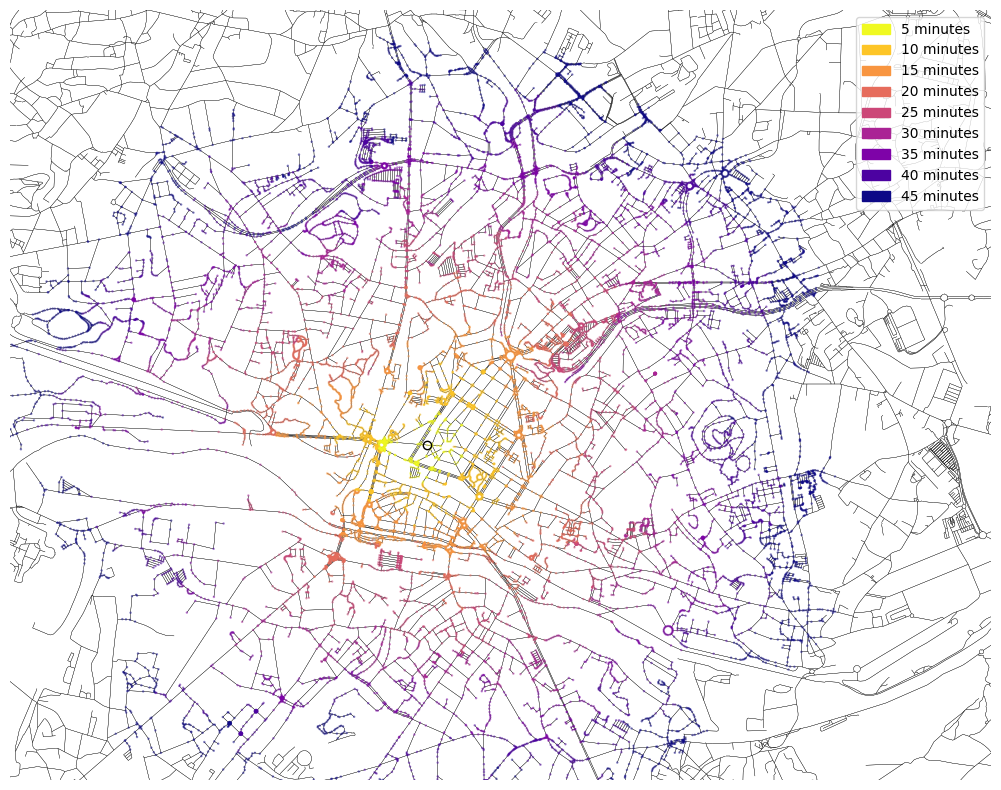

In [16]:
# plot map 
legend_patches = []
for idx, c in enumerate(reversed(iso_colors)):
    legend_patches.append(mpatches.Patch(color=c, label=f'{trip_times[idx]} minutes'))
fig, ax = plt.subplots(figsize=(20, 10))
ox.plot_graph(G, ax=ax, node_color=nc, node_size=ns, node_alpha=0.5, node_zorder=2, bgcolor='w', edge_linewidth=0.2, edge_color='k', show=False, close=False)
ax.plot(G.nodes[source_node]['x'], G.nodes[source_node]['y'], 'o', markerfacecolor=(0,0,0,0), markeredgecolor=(0,0,0,1))
ax.set_xlim(4.4,4.5)
ax.set_ylim(50.39,50.44)
ax.legend(handles=legend_patches, loc='upper right')

In [17]:
import pandas as pd
import geopandas as gpd

In [18]:
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

In [19]:
gdf.head()

,version,tags,y,x,visible,timestamp,changeset,osmid,geometry,zone
1547383,0,None,50.456631,4.527965,False,0,0,1547383,POINT (4.52797 50.45663),-1
1103037320,0,None,50.456554,4.527936,False,0,0,1103037320,POINT (4.52794 50.45655),-1
38464169,0,None,50.456478,4.527940,False,0,0,38464169,POINT (4.52794 50.45648),-1
1547382,0,None,50.456799,4.528312,False,0,0,1547382,POINT (4.52831 50.4568),-1
9630157482,0,None,50.456818,4.528194,False,0,0,9630157482,POINT (4.52819 50.45682),-1


In [25]:
from shapely import concave_hull

In [32]:
zone_dict ={}
k=0
for zone, subset in gdf.groupby('zone'):
    zone_dict.update({k: {'geometry': concave_hull(subset.union_all(), ratio=0.4), 'zone': zone}})
    k+=1

In [33]:
gdf_zones = gpd.GeoDataFrame.from_dict(zone_dict, orient='index')

In [34]:
# legend_patches.append(mpatches.Patch(color='w', label=f'>{trip_times[idx]} minutes'))

<Axes: >

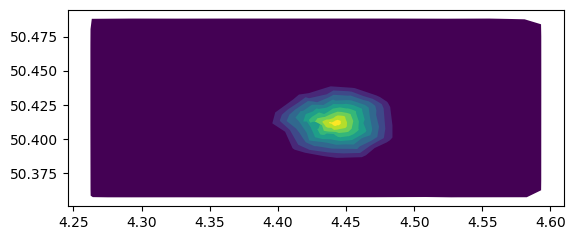

In [35]:
gdf_zones.plot('zone') #, legend_patches=legend_patches)

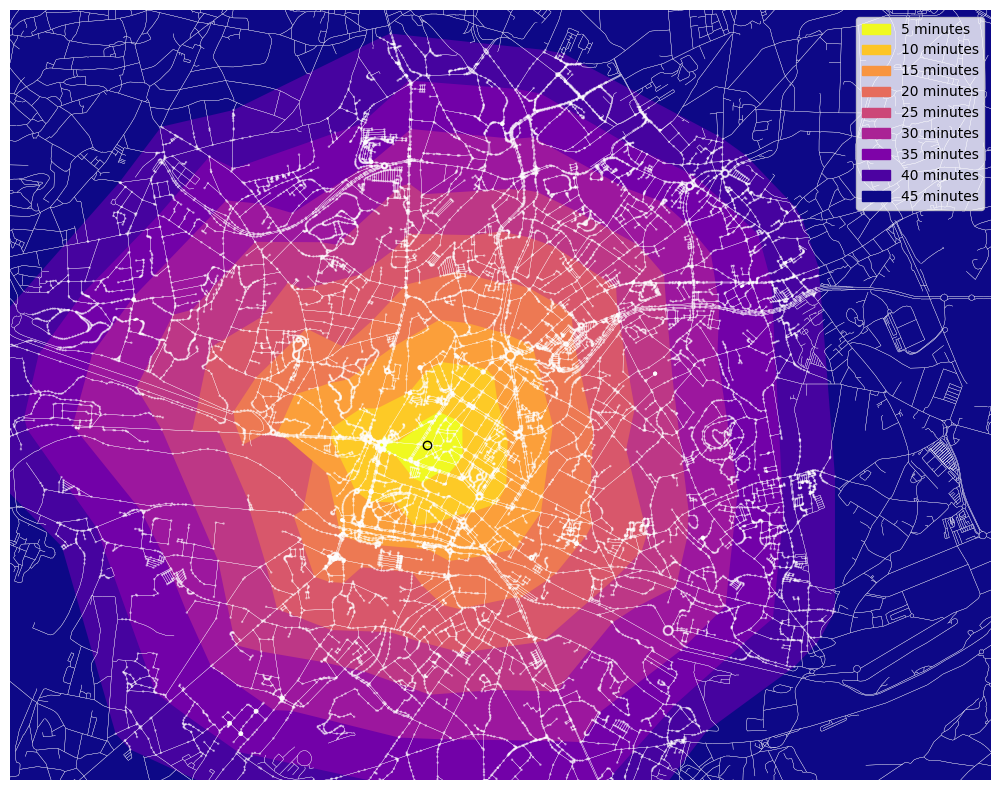

In [36]:
# plot ischrone map using concave hull
legend_patches = []
for idx, c in enumerate(reversed(iso_colors)):
    legend_patches.append(mpatches.Patch(color=c, label=f'{trip_times[idx]} minutes'))
fig, ax = plt.subplots(figsize=(20, 10))
gdf_zones.plot('zone', cmap='plasma', ax=ax) #, legend_patches=legend_patches)
ox.plot_graph(G, ax=ax, node_color='w', node_size=ns, node_alpha=0.5, node_zorder=2, bgcolor='w', edge_linewidth=0.2, edge_color='w', show=False, close=False)
ax.plot(G.nodes[source_node]['x'], G.nodes[source_node]['y'], 'o', markerfacecolor=(0,0,0,0), markeredgecolor=(0,0,0,1))
ax.set_xlim(4.4,4.5)
ax.set_ylim(50.39,50.44)
ax.legend(handles=legend_patches, loc='upper right')

In [37]:
from shapely import Point, LineString, Polygon
from descartes import PolygonPatch

In [74]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, source_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [76]:
from tqdm.auto import tqdm

0it [00:00, ?it/s]

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

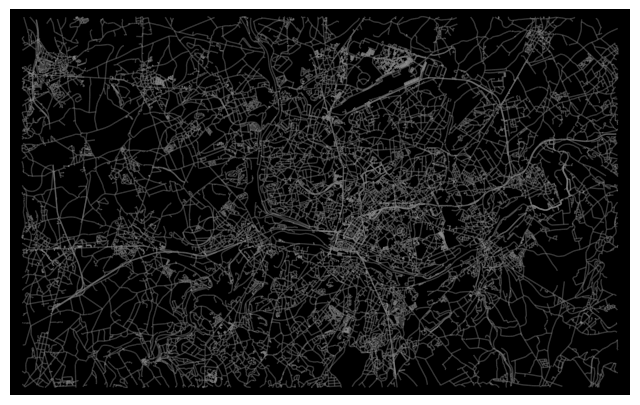

In [77]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
for polygon, fc in tqdm(zip(isochrone_polys, iso_colors)):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [ ]:
polygon

In [ ]:
gdf_poly = gpd.GeoDataFrame.from_dict(poly_dict, orient='index')

In [ ]:
gdf_poly.plot(color=gdf_poly['color'])

In [ ]:
gdf

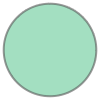

In [78]:
PolyGpolygon